In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from google.colab import files
import zipfile
import matplotlib.pyplot as plt

# ==============================================
# 1. UPLOAD AND EXTRACT DATA
# ==============================================
print("=" * 70)
print("STEP 1: UPLOAD YOUR DATA")
print("=" * 70)

print("1. Create a folder called 'shoulder_data' on your PC")
print("2. Put ALL 12 CSV files in that folder")
print("3. Zip the folder as 'shoulder_data.zip'")
print("4. Upload it now:")

uploaded = files.upload()

for filename in uploaded.keys():
    print(f"✓ Uploaded: {filename}")
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('/content/')
        print(f"✓ Extracted to /content/shoulder_data/")

# ==============================================
# 2. DATA PROCESSING CLASS (FIXED VERSION)
# ==============================================
class ShoulderDataProcessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.all_data = []
        self.feature_cols = None

    def extract_movement_from_filename(self, filename):
        filename_lower = filename.lower()
        if 'steady' in filename_lower:
            return 'STEADY'
        elif 'flexion' in filename_lower:
            return 'SHOULDER_FLEXION'
        elif 'extension' in filename_lower:
            return 'SHOULDER_EXTENSION'
        elif 'abduction' in filename_lower:
            return 'SHOULDER_ABDUCTION'
        elif 'adduction' in filename_lower:
            return 'SHOULDER_ADDUCTION'
        elif 'circumduction' in filename_lower:
            return 'SHOULDER_CIRCUMDUCTION'
        else:
            return 'UNKNOWN'

    def extract_child_info(self, filename):
        if 'grade8' in filename.lower():
            return 'GRADE8'
        elif 'grade9' in filename.lower():
            return 'GRADE9'
        else:
            return 'UNKNOWN'

    def load_all_files(self, data_dir='/content/shoulder_data/raw_data'):
        print("=" * 70)
        print("LOADING ALL DATA")
        print("=" * 70)

        csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
        print(f"Found {len(csv_files)} CSV files\n")

        for i, filename in enumerate(sorted(csv_files), 1):
            filepath = os.path.join(data_dir, filename)

            # Load ALL columns
            df = pd.read_csv(filepath)

            # Add metadata
            df['Movement'] = self.extract_movement_from_filename(filename)
            df['Child'] = self.extract_child_info(filename)
            df['Filename'] = filename

            self.all_data.append(df)

            print(f"{i:2d}. {filename:35} | Rows: {len(df):5d} | "
                  f"Movement: {df['Movement'].iloc[0]:25} | Child: {df['Child'].iloc[0]}")

        # Combine all data
        if self.all_data:
            combined_df = pd.concat(self.all_data, ignore_index=True)

            print("\n" + "=" * 70)
            print("DATASET SUMMARY")
            print("=" * 70)
            print(f"Total samples: {len(combined_df)}")
            print(f"Total columns: {len(combined_df.columns)}")

            # Identify feature columns (remove metadata)
            metadata_cols = ['Timestamp', 'Gender', 'Age', 'Arm', 'Status',
                           'Movement', 'Child', 'Filename']
            self.feature_cols = [col for col in combined_df.columns
                               if col not in metadata_cols]

            print(f"\nFeature columns: {len(self.feature_cols)}")
            print("Features:", self.feature_cols)

            print("\nMovement distribution:")
            print(combined_df['Movement'].value_counts())

            return combined_df
        return None

    def create_sequences(self, combined_df, sequence_length=50, step_size=25):
        print("\n" + "=" * 70)
        print("CREATING SEQUENCES FOR LSTM")
        print("=" * 70)

        if self.feature_cols is None:
            print("Error: No features identified!")
            return None, None, None

        features = combined_df[self.feature_cols].values
        movement_labels = combined_df['Movement'].values
        child_labels = combined_df['Child'].values

        # Scale features
        features_scaled = self.scaler.fit_transform(features)

        # Encode labels
        y_encoded = self.label_encoder.fit_transform(movement_labels)

        # Create sequences
        X_sequences = []
        y_sequences = []
        child_sequences = []

        # Group by child and movement
        for child in ['GRADE8', 'GRADE9']:
            for movement in combined_df['Movement'].unique():
                mask = (combined_df['Child'] == child) & (combined_df['Movement'] == movement)
                if mask.sum() == 0:
                    continue

                data = features_scaled[mask]
                labels = y_encoded[mask]

                # Create sequences from this group
                for i in range(0, len(data) - sequence_length + 1, step_size):
                    X_sequences.append(data[i:i + sequence_length])
                    y_sequences.append(labels[i + sequence_length - 1])  # Last label
                    child_sequences.append(child)

        X = np.array(X_sequences)
        y = np.array(y_sequences)
        child_info = np.array(child_sequences)

        print(f"Created {len(X)} sequences")
        print(f"Sequence shape: {X.shape}")
        print(f"\nSequences per child:")
        for child in np.unique(child_info):
            count = np.sum(child_info == child)
            print(f"  {child}: {count} sequences")

        return X, y, child_info

    def prepare_splits(self, X, y, child_info, strategy='mixed'):
        print("\n" + "=" * 70)
        print(f"PREPARING DATA SPLIT: {strategy.upper()}")
        print("=" * 70)

        if strategy == 'by_child':
            # Train on Grade 8, Test on Grade 9
            train_mask = child_info == 'GRADE8'
            test_mask = child_info == 'GRADE9'

            X_train = X[train_mask]
            y_train = y[train_mask]
            X_test = X[test_mask]
            y_test = y[test_mask]

            # Split train into train/val
            X_train, X_val, y_train, y_val = train_test_split(
                X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
            )

            print(f"Train (GRADE8): {len(X_train)} sequences")
            print(f"Val (GRADE8): {len(X_val)} sequences")
            print(f"Test (GRADE9): {len(X_test)} sequences")

        else:  # mixed strategy
            # Mix both children
            X_train, X_test, y_train, y_test, child_train, child_test = train_test_split(
                X, y, child_info, test_size=0.2, random_state=42, stratify=y
            )

            # Split train into train/val
            X_train, X_val, y_train, y_val = train_test_split(
                X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
            )

            print(f"Train: {len(X_train)} sequences")
            print(f"Val: {len(X_val)} sequences")
            print(f"Test: {len(X_test)} sequences")

        # One-hot encode
        num_classes = len(self.label_encoder.classes_)
        y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
        y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)
        y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)

        return X_train, X_val, X_test, y_train_oh, y_val_oh, y_test_oh

# ==============================================
# 3. LOAD AND PROCESS DATA
# ==============================================
processor = ShoulderDataProcessor()
combined_df = processor.load_all_files()

if combined_df is not None:
    # Create sequences
    X, y, child_info = processor.create_sequences(combined_df, sequence_length=50, step_size=10)

    # Prepare splits (choose 'by_child' or 'mixed')
    X_train, X_val, X_test, y_train, y_val, y_test = processor.prepare_splits(
        X, y, child_info, strategy='mixed'  # Change to 'by_child' for other strategy
    )

# ==============================================
# 4. BUILD AND TRAIN LSTM MODEL
# ==============================================
def build_lstm_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall']
    )

    return model

print("\n" + "=" * 70)
print("BUILDING LSTM MODEL")
print("=" * 70)

input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

model = build_lstm_model(input_shape, num_classes)
model.summary()

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
    )
]

# Train
print("\n" + "=" * 70)
print("TRAINING MODEL")
print("=" * 70)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# ==============================================
# 5. EVALUATE MODEL
# ==============================================
print("\n" + "=" * 70)
print("EVALUATION RESULTS")
print("=" * 70)

# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")

# ==============================================
# 6. SAVE MODEL AND ARTIFACTS
# ==============================================
import joblib
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save model
model.save(f'/content/shoulder_lstm_model_{timestamp}.h5')
joblib.dump(processor.scaler, f'/content/scaler_{timestamp}.pkl')
joblib.dump(processor.label_encoder, f'/content/label_encoder_{timestamp}.pkl')

print("\n" + "=" * 70)
print("MODEL SAVED!")
print("=" * 70)
print(f"Model: shoulder_lstm_model_{timestamp}.h5")
print(f"Scaler: scaler_{timestamp}.pkl")
print(f"Label Encoder: label_encoder_{timestamp}.pkl")

# Download files
print("\n" + "=" * 70)
print("DOWNLOAD FILES")
print("=" * 70)

files_to_download = [
    f'/content/shoulder_lstm_model_{timestamp}.h5',
    f'/content/scaler_{timestamp}.pkl',
    f'/content/label_encoder_{timestamp}.pkl'
]

for filepath in files_to_download:
    if os.path.exists(filepath):
        print(f"Downloading: {os.path.basename(filepath)}")
        files.download(filepath)

STEP 1: UPLOAD YOUR DATA
1. Create a folder called 'shoulder_data' on your PC
2. Put ALL 12 CSV files in that folder
3. Zip the folder as 'shoulder_data.zip'
4. Upload it now:


Saving shoulder_data.zip to shoulder_data (1).zip
✓ Uploaded: shoulder_data (1).zip
✓ Extracted to /content/shoulder_data/
LOADING ALL DATA
Found 12 CSV files

 1. grade8_abduction.csv                | Rows:   244 | Movement: SHOULDER_ABDUCTION        | Child: GRADE8
 2. grade8_adduction.csv                | Rows:   217 | Movement: SHOULDER_ADDUCTION        | Child: GRADE8
 3. grade8_circumduction.csv            | Rows:   167 | Movement: SHOULDER_CIRCUMDUCTION    | Child: GRADE8
 4. grade8_extension.csv                | Rows:   180 | Movement: SHOULDER_EXTENSION        | Child: GRADE8
 5. grade8_flexion.csv                  | Rows:   167 | Movement: SHOULDER_FLEXION          | Child: GRADE8
 6. grade8_steady.csv                   | Rows:   176 | Movement: STEADY                    | Child: GRADE8
 7. grade9_abduction.csv                | Rows:   163 | Movement: SHOULDER_ABDUCTION        | Child: GRADE9
 8. grade9_adduction.csv                | Rows:   275 | Movement: SHOULDER_ADDUCTION

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,398 (130.46 KB)

 Trainable params: 33,206 (129.71 KB)

 Non-trainable params: 192 (768.00 B)


TRAINING MODEL
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - Precision: 0.1982 - Recall: 0.0609 - accuracy: 0.1480 - loss: 2.3610 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2353 - val_loss: 1.7765 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - Precision: 0.4228 - Recall: 0.1063 - accuracy: 0.2612 - loss: 1.8804 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2647 - val_loss: 1.7270 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - Precision: 0.5558 - Recall: 0.1251 - accuracy: 0.3745 - loss: 1.6251 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3529 - val_loss: 1.7042 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - Precision: 0.5880 - Recall: 0.1140 - accuracy: 0.3534 - loss: 1.6320 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4412 - val_loss: 1.6855 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━

Test Accuracy:  0.8333
Test Precision: 0.9062
Test Recall:    0.6905

MODEL SAVED!
Model: shoulder_lstm_model_20260104_092441.h5
Scaler: scaler_20260104_092441.pkl
Label Encoder: label_encoder_20260104_092441.pkl

DOWNLOAD FILES
Downloading: shoulder_lstm_model_20260104_092441.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: scaler_20260104_092441.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: label_encoder_20260104_092441.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LOADING SAVED MODEL
✓ Model loaded successfully!
Model input shape: (None, 50, 13)
Classes: ['SHOULDER_ABDUCTION' 'SHOULDER_ADDUCTION' 'SHOULDER_CIRCUMDUCTION'
 'SHOULDER_EXTENSION' 'SHOULDER_FLEXION' 'STEADY']

TESTING ON EXISTING TEST SET
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step

PERFORMANCE METRICS
Test Accuracy: 0.8333

CLASSIFICATION REPORT
                        precision    recall  f1-score   support

    SHOULDER_ABDUCTION       0.80      0.67      0.73         6
    SHOULDER_ADDUCTION       0.70      0.88      0.78         8
SHOULDER_CIRCUMDUCTION       0.71      0.71      0.71         7
    SHOULDER_EXTENSION       0.83      0.71      0.77         7
      SHOULDER_FLEXION       1.00      1.00      1.00         7
                STEADY       1.00      1.00      1.00         7

              accuracy                           0.83        42
             macro avg       0.84      0.83      0.83        42
          weighted avg       0.84      0.83      0.83        42



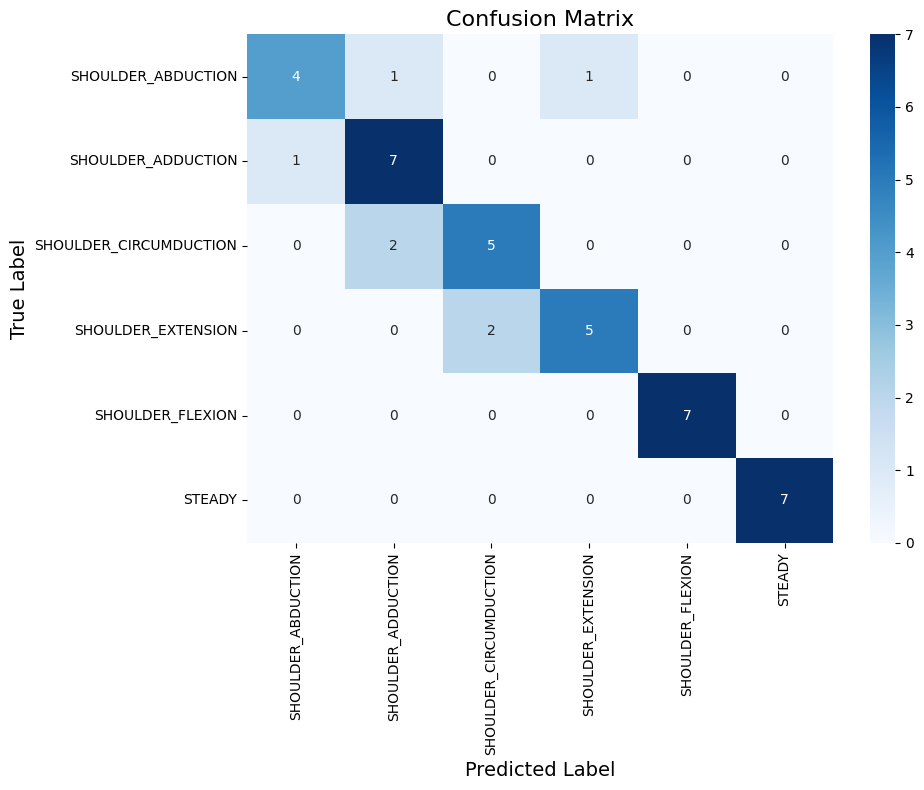

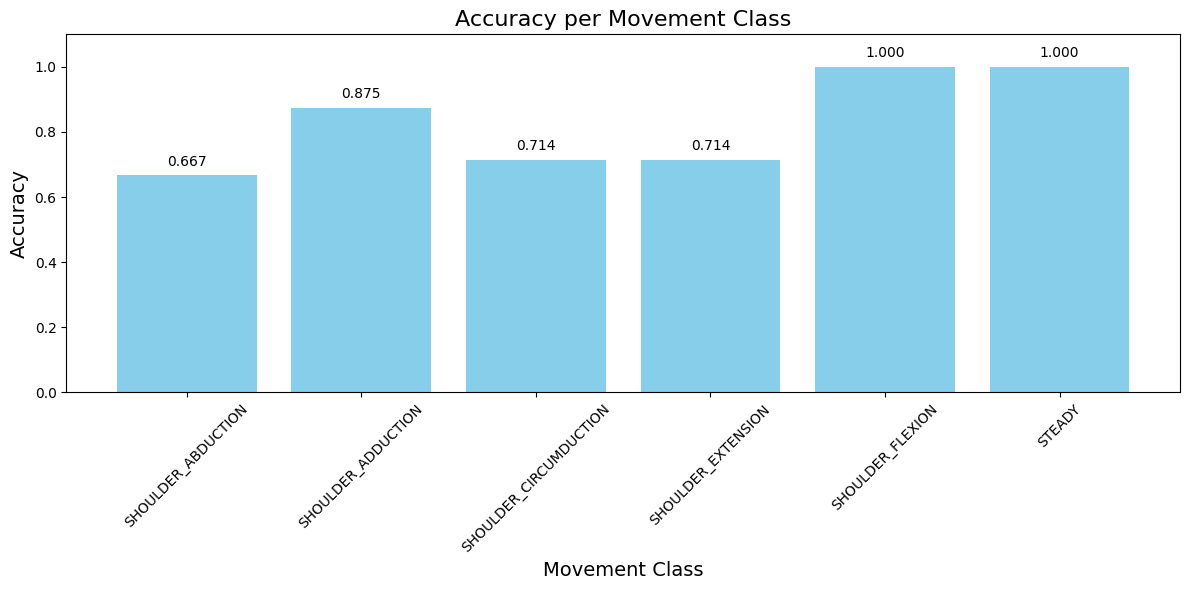

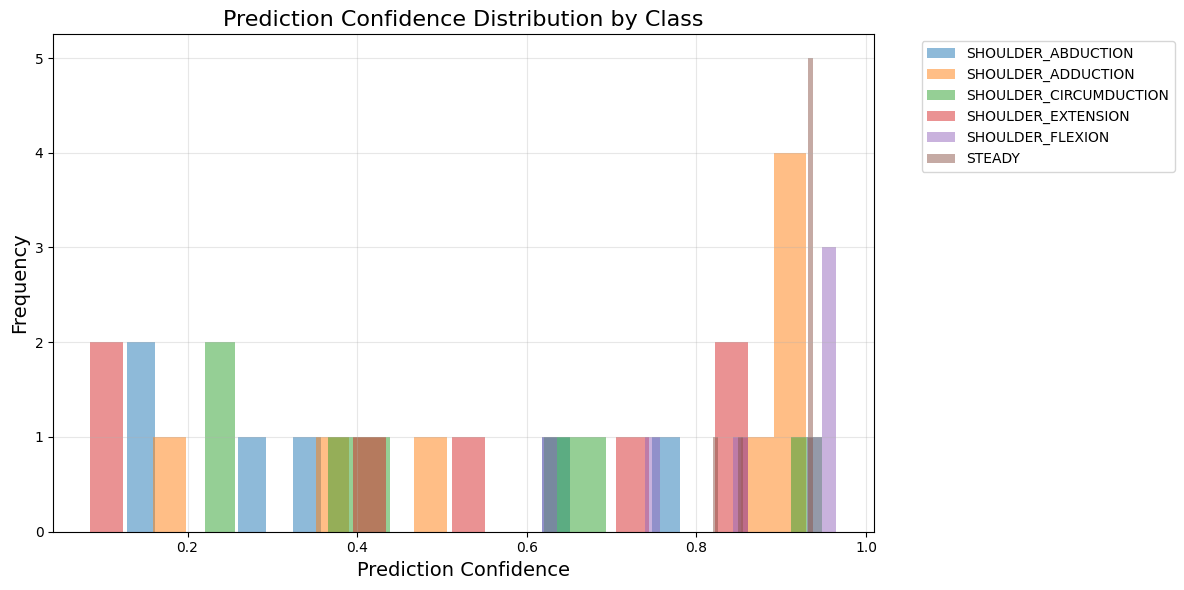


MISCLASSIFICATION ANALYSIS
Total misclassified: 7 / 42 (16.67%)

First 10 misclassifications:
  True: SHOULDER_EXTENSION        → Pred: SHOULDER_CIRCUMDUCTION    (Confidence: 0.727)
  True: SHOULDER_CIRCUMDUCTION    → Pred: SHOULDER_ADDUCTION        (Confidence: 0.516)
  True: SHOULDER_ABDUCTION        → Pred: SHOULDER_EXTENSION        (Confidence: 0.397)
  True: SHOULDER_EXTENSION        → Pred: SHOULDER_CIRCUMDUCTION    (Confidence: 0.832)
  True: SHOULDER_CIRCUMDUCTION    → Pred: SHOULDER_ADDUCTION        (Confidence: 0.336)
  True: SHOULDER_ABDUCTION        → Pred: SHOULDER_ADDUCTION        (Confidence: 0.321)
  True: SHOULDER_ADDUCTION        → Pred: SHOULDER_ABDUCTION        (Confidence: 0.308)

TESTING SINGLE SEQUENCE
True class: SHOULDER_EXTENSION
Predicted: SHOULDER_EXTENSION (Confidence: 0.609)

All class probabilities:
  SHOULDER_ABDUCTION       : 0.1701
  SHOULDER_ADDUCTION       : 0.0411
  SHOULDER_CIRCUMDUCTION   : 0.1120
  SHOULDER_EXTENSION       : 0.6088
  SHOULDER_FL

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import joblib

# ==============================================
# 1. LOAD THE SAVED MODEL AND ARTIFACTS
# ==============================================
print("=" * 70)
print("LOADING SAVED MODEL")
print("=" * 70)

# Load model (change filename to your actual saved model)
model = tf.keras.models.load_model('/content/shoulder_lstm_model_20260104_092441.h5')

# Load scaler and label encoder
scaler = joblib.load('/content/scaler_20260104_092441.pkl')
label_encoder = joblib.load('/content/label_encoder_20260104_092441.pkl')

print("✓ Model loaded successfully!")
print(f"Model input shape: {model.input_shape}")
print(f"Classes: {label_encoder.classes_}")

# ==============================================
# 2. LOAD YOUR TEST DATA
# ==============================================
# If you still have X_test, y_test from training:
print("\n" + "=" * 70)
print("TESTING ON EXISTING TEST SET")
print("=" * 70)

# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# ==============================================
# 3. EVALUATION METRICS
# ==============================================
print("\n" + "=" * 70)
print("PERFORMANCE METRICS")
print("=" * 70)

# Calculate accuracy
accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(y_true, y_pred,
                          target_names=label_encoder.classes_))

# ==============================================
# 4. VISUALIZATIONS
# ==============================================
# 4.1 Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

# 4.2 Class-wise Accuracy
class_accuracies = []
for i in range(len(label_encoder.classes_)):
    mask = y_true == i
    if np.sum(mask) > 0:
        class_acc = np.mean(y_pred[mask] == y_true[mask])
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(label_encoder.classes_)), class_accuracies, color='skyblue')
plt.title('Accuracy per Movement Class', fontsize=16)
plt.xlabel('Movement Class', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(range(len(label_encoder.classes_)), label_encoder.classes_, rotation=45)
plt.ylim([0, 1.1])

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 4.3 Prediction Confidence Distribution
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(label_encoder.classes_):
    mask = y_true == i
    if np.sum(mask) > 0:
        confidences = y_pred_probs[mask, i]
        plt.hist(confidences, alpha=0.5, label=class_name, bins=20)

plt.title('Prediction Confidence Distribution by Class', fontsize=16)
plt.xlabel('Prediction Confidence', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4.4 Misclassification Analysis
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"\n" + "=" * 70)
print("MISCLASSIFICATION ANALYSIS")
print("=" * 70)
print(f"Total misclassified: {len(misclassified_indices)} / {len(y_true)} ({len(misclassified_indices)/len(y_true)*100:.2f}%)")

if len(misclassified_indices) > 0:
    print("\nFirst 10 misclassifications:")
    for i in misclassified_indices[:10]:
        true_class = label_encoder.classes_[y_true[i]]
        pred_class = label_encoder.classes_[y_pred[i]]
        confidence = y_pred_probs[i, y_pred[i]]
        print(f"  True: {true_class:25} → Pred: {pred_class:25} (Confidence: {confidence:.3f})")

# ==============================================
# 5. TEST WITH NEW DATA (if available)
# ==============================================
def test_single_sequence(model, scaler, label_encoder, sequence):
    """
    Test the model on a single sequence
    sequence: numpy array of shape (timesteps, features)
    """
    # Scale the sequence
    sequence_scaled = scaler.transform(sequence)
    sequence_scaled = sequence_scaled.reshape(1, sequence.shape[0], sequence.shape[1])

    # Make prediction
    prediction_probs = model.predict(sequence_scaled, verbose=0)
    predicted_class_idx = np.argmax(prediction_probs)
    predicted_class = label_encoder.classes_[predicted_class_idx]
    confidence = prediction_probs[0, predicted_class_idx]

    return predicted_class, confidence, prediction_probs

# Example: Test on first test sequence
print("\n" + "=" * 70)
print("TESTING SINGLE SEQUENCE")
print("=" * 70)

if len(X_test) > 0:
    test_sequence = X_test[0]
    true_class_idx = np.argmax(y_test[0])
    true_class = label_encoder.classes_[true_class_idx]

    pred_class, confidence, probs = test_single_sequence(model, scaler, label_encoder, test_sequence)

    print(f"True class: {true_class}")
    print(f"Predicted: {pred_class} (Confidence: {confidence:.3f})")
    print(f"\nAll class probabilities:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"  {class_name:25}: {probs[0, i]:.4f}")

In [ ]:
# testing the process

In [ ]:
# =========== SIMPLE TEST CODE ===========

# 1. FIRST: Upload your model files (run this cell first)
from google.colab import files
import tensorflow as tf
import joblib
import numpy as np
import pandas as pd

print("📤 STEP 1: Upload your 3 saved files:")
print("   - shoulder_model_2children_*.h5")
print("   - scaler_2children_*.pkl")
print("   - label_encoder_2children_*.pkl")
print("\nClick 'Choose Files' and select all 3 files:")

uploaded = files.upload()

# Find uploaded files
model_file = [f for f in uploaded.keys() if f.endswith('.h5')][0]
scaler_file = [f for f in uploaded.keys() if 'scaler' in f][0]
encoder_file = [f for f in uploaded.keys() if 'label_encoder' in f][0]

# Load everything
model = tf.keras.models.load_model(model_file)
scaler = joblib.load(scaler_file)
label_encoder = joblib.load(encoder_file)

print(f"\n✅ Loaded: {model_file}")
print(f"   Input shape needed: {model.input_shape}")
print(f"   Classes: {list(label_encoder.classes_)}")

# ========================================

# 2. SECOND: Upload NEW test data CSV (run this cell)
print("\n📤 STEP 2: Upload NEW CSV file to test:")
print("Example: grade8_flexion_test.csv")

test_uploaded = files.upload()
test_filename = list(test_uploaded.keys())[0]
test_content = test_uploaded[test_filename]

# ========================================

# 3. THIRD: Test the data (run this cell)
import io

# Read the test CSV
df_test = pd.read_csv(io.StringIO(test_content.decode('utf-8')))

# Check what columns we have
print(f"\n📊 Testing file: {test_filename}")
print(f"   Rows: {len(df_test)}")
print(f"   Columns: {list(df_test.columns)}")

# Prepare features (use only columns that exist)
feature_cols = ['AccelX', 'AccelY', 'AccelZ',
                'GyroX', 'GyroY', 'GyroZ',
                'AngleX', 'AngleY', 'AngleZ',
                'FlexionAngle', 'AbductionAngle',
                'RotationAngle', 'ShoulderElevation']

# Keep only columns that exist in test data
available_cols = [col for col in feature_cols if col in df_test.columns]
print(f"   Using features: {available_cols}")

# Extract data
test_data = df_test[available_cols].values

# Check if we have enough data (need 100 timesteps)
sequence_length = 100  # Same as your training
if len(test_data) < sequence_length:
    print(f"❌ Need at least {sequence_length} rows, but only have {len(test_data)}")
else:
    # Create sequence (take first 100 rows)
    sequence = test_data[:sequence_length]

    # Scale it
    sequence_scaled = scaler.transform(sequence)

    # Reshape for model (1, 100, features)
    sequence_reshaped = sequence_scaled.reshape(1, sequence_length, len(available_cols))

    # Make prediction
    prediction = model.predict(sequence_reshaped, verbose=0)
    predicted_class_idx = np.argmax(prediction[0])
    predicted_class = label_encoder.classes_[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx]

    print(f"\n🎯 PREDICTION RESULT:")
    print(f"   Predicted: {predicted_class}")
    print(f"   Confidence: {confidence:.2%}")

    # Show all probabilities
    print(f"\n📈 All probabilities:")
    for i, class_name in enumerate(label_encoder.classes_):
        prob = prediction[0][i]
        print(f"   {class_name:25}: {prob:.2%}")

# ========================================

# 4. FOURTH: Test multiple sequences (run this if you want)
print("\n" + "="*50)
print("Testing ALL sequences in file...")

def test_all_sequences(data, window=100, step=50):
    """Test overlapping windows from the data"""
    predictions_all = []

    for start in range(0, len(data) - window + 1, step):
        seq = data[start:start + window]
        seq_scaled = scaler.transform(seq)
        seq_reshaped = seq_scaled.reshape(1, window, len(available_cols))

        pred = model.predict(seq_reshaped, verbose=0)
        pred_idx = np.argmax(pred[0])
        pred_class = label_encoder.classes_[pred_idx]
        confidence = pred[0][pred_idx]

        predictions_all.append({
            'start': start,
            'end': start + window,
            'prediction': pred_class,
            'confidence': confidence
        })

    return predictions_all

if len(test_data) >= sequence_length:
    all_predictions = test_all_sequences(test_data)

    print(f"\nTested {len(all_predictions)} sequences:")

    # Count predictions
    from collections import Counter
    pred_counts = Counter([p['prediction'] for p in all_predictions])

    for movement, count in pred_counts.items():
        percentage = (count / len(all_predictions)) * 100
        avg_conf = np.mean([p['confidence'] for p in all_predictions
                           if p['prediction'] == movement])
        print(f"   {movement:25}: {count:3d} times ({percentage:.1f}%), avg confidence: {avg_conf:.2%}")

    # Most common prediction
    most_common = max(pred_counts.items(), key=lambda x: x[1])
    print(f"\n✅ FINAL VERDICT: Most likely movement is '{most_common[0]}'")

📤 STEP 1: Upload your 3 saved files:
   - shoulder_model_2children_*.h5
   - scaler_2children_*.pkl
   - label_encoder_2children_*.pkl

Click 'Choose Files' and select all 3 files:


Saving label_encoder_20260104_092441.pkl to label_encoder_20260104_092441 (1).pkl
Saving scaler_20260104_092441.pkl to scaler_20260104_092441 (1).pkl
Saving shoulder_lstm_model_20260104_092441.h5 to shoulder_lstm_model_20260104_092441 (2).h5

✅ Loaded: shoulder_lstm_model_20260104_092441 (2).h5
   Input shape needed: (None, 50, 13)
   Classes: ['SHOULDER_ABDUCTION', 'SHOULDER_ADDUCTION', 'SHOULDER_CIRCUMDUCTION', 'SHOULDER_EXTENSION', 'SHOULDER_FLEXION', 'STEADY']

📤 STEP 2: Upload NEW CSV file to test:
Example: grade8_flexion_test.csv


Saving grade9_flexion.csv to grade9_flexion.csv

📊 Testing file: grade9_flexion.csv
   Rows: 256
   Columns: ['Timestamp', 'Gender', 'Age', 'Arm', 'Status', 'Movement', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'AngleX', 'AngleY', 'AngleZ', 'FlexionAngle', 'AbductionAngle', 'RotationAngle', 'ShoulderElevation']
   Using features: ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'AngleX', 'AngleY', 'AngleZ', 'FlexionAngle', 'AbductionAngle', 'RotationAngle', 'ShoulderElevation']

🎯 PREDICTION RESULT:
   Predicted: SHOULDER_FLEXION
   Confidence: 96.19%

📈 All probabilities:
   SHOULDER_ABDUCTION       : 0.92%
   SHOULDER_ADDUCTION       : 0.58%
   SHOULDER_CIRCUMDUCTION   : 0.88%
   SHOULDER_EXTENSION       : 0.18%
   SHOULDER_FLEXION         : 96.19%
   STEADY                   : 1.24%

Testing ALL sequences in file...

Tested 4 sequences:
   SHOULDER_FLEXION         :   4 times (100.0%), avg confidence: 95.43%

✅ FINAL VERDICT: Most likely movement is 'SHOULDER